# Evaluate a BiVAE model trained on Rotated MNIST
Jan 23, 2021

## Load libraries

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import os,sys
import re
import math
from datetime import datetime
import time
sys.dont_write_bytecode = True

In [ ]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from typing import List, Set, Dict, Tuple, Optional, Iterable, Mapping, Union, Callable, TypeVar

from pprint import pprint
from ipdb import set_trace as brpt

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from  torch.linalg import norm as tnorm
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.tuner.tuning import Tuner


# Select Visible GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Set Path 
1. Add project root and src folders to `sys.path`
2. Set DATA_ROOT to `maptile_v2` folder

In [ ]:
this_nb_path = Path(os.getcwd())
ROOT = this_nb_path.parent
SRC = ROOT/'src'
DATA_ROOT = Path("/data/hayley-old/maptiles_v2/")
paths2add = [this_nb_path, ROOT]

print("Project root: ", str(ROOT))
print('Src folder: ', str(SRC))
print("This nb path: ", str(this_nb_path))


for p in paths2add:
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))
        print(f"\n{str(p)} added to the path.")
        
# print(sys.path)

In [ ]:
# Data transforms
from src.data.transforms.transforms import Identity, Unnormalizer, LinearRescaler
from src.data.transforms.functional import unnormalize

# Utils
from src.visualize.utils import show_timg, show_timgs, show_batch, make_grid_from_tensors
from src.utils.misc import info, get_next_version_path
from collections import OrderedDict

In [53]:
# DataModules
from src.data.datamodules import MNISTDataModule, MNISTMDataModule, MonoMNISTDataModule
from src.data.datamodules import MultiMonoMNISTDataModule
from src.data.datamodules.multisource_rotated_mnist_datamodule import MultiRotatedMNISTDataModule
from src.data.datamodules.multisource_maptiles_datamodule import MultiMaptilesDataModule


# plModules
from src.models.plmodules.vanilla_vae import VanillaVAE
from src.models.plmodules.iwae import IWAE
from src.models.plmodules.bilatent_vae import BiVAE

# Evaluations
from torch.utils.tensorboard import SummaryWriter
from pytorch_lightning.utilities.cloud_io import load as pl_load
from src.evaluator.qualitative import save_content_transfers, save_style_transfers, run_both_transfers

# Evaluation NB to load and evaluate a trained model
Steps:
- Define the architecutre of the model to load
- Load the model at `ckpt_path`
- Run the following evaluations

Evaluations:
1. Evaluation of the generative model
- Quantitative: `best_score`, which is the lowest loss computed as an average loss per datapt in the validation set. The loss is the estimate of the negative maginal log-likelihood of the observed data based on the trained model

- Qualitative: 
  - Reconstruction of datapts from train/val datasets
    - This evaluates how well the generative model (encoder-decoder) preserves the information needed to reconstruct the input data after having learned/trained/optimized jointly with/in the presence of its adversary, the style-classifier/discriminator

2. Evaluation of the discriminator
- How well does it discriminate? 
  - based on a style code: the model should predict the style label of the input datapt well
    - Compute the `loss_s` over the train/val datasets (as an expectation, ie. loss value per datapt/image)
  - based on a content code: the model should say "I'm not sure, aka. all style labels seem equally probable"
    - Compute the `loss_s` over the train/val datasets (as an expectation, ie. loss value per datapt/image)
  - Q: what is the range of the `loss_s` or `loss_c` for a good style-classifer?
   

## Define data for evaluation

Unique styles:  ['StamenTonerBackground']
Unique styles:  ['StamenTonerBackground']
Unique styles:  ['StamenTonerBackground']
n_train, n_val:  40 16
train channelwise_mean,std:  [0.81417532 0.81417532 0.81417532] [0.33933624 0.33933624 0.33933624]
shape:  torch.Size([32, 3, 128, 128])
dtype:  torch.float32
min, max:  -2.3993173 0.54761225


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[['8297', '8299', '8298', '8297', '8299', '8295', '8295', '8300', '8298', '8300', '8298', '8294', '8294', '8293', '8300', '8297', '8301', '8296', '8297', '8299', '8300', '8293', '8295', '8294', '8299', '8297', '8295', '8295', '8294', '8300', '8301', '8296'], ['5635', '5636', '5639', '5637', '5637', '5639', '5638', '5639', '5633', '5635', '5637', '5637', '5635', '5637', '5637', '5636', '5638', '5636', '5639', '5633', '5633', '5639', '5636', '5636', '5635', '5633', '5635', '5634', '5638', '5638', '5637', '5638']]
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


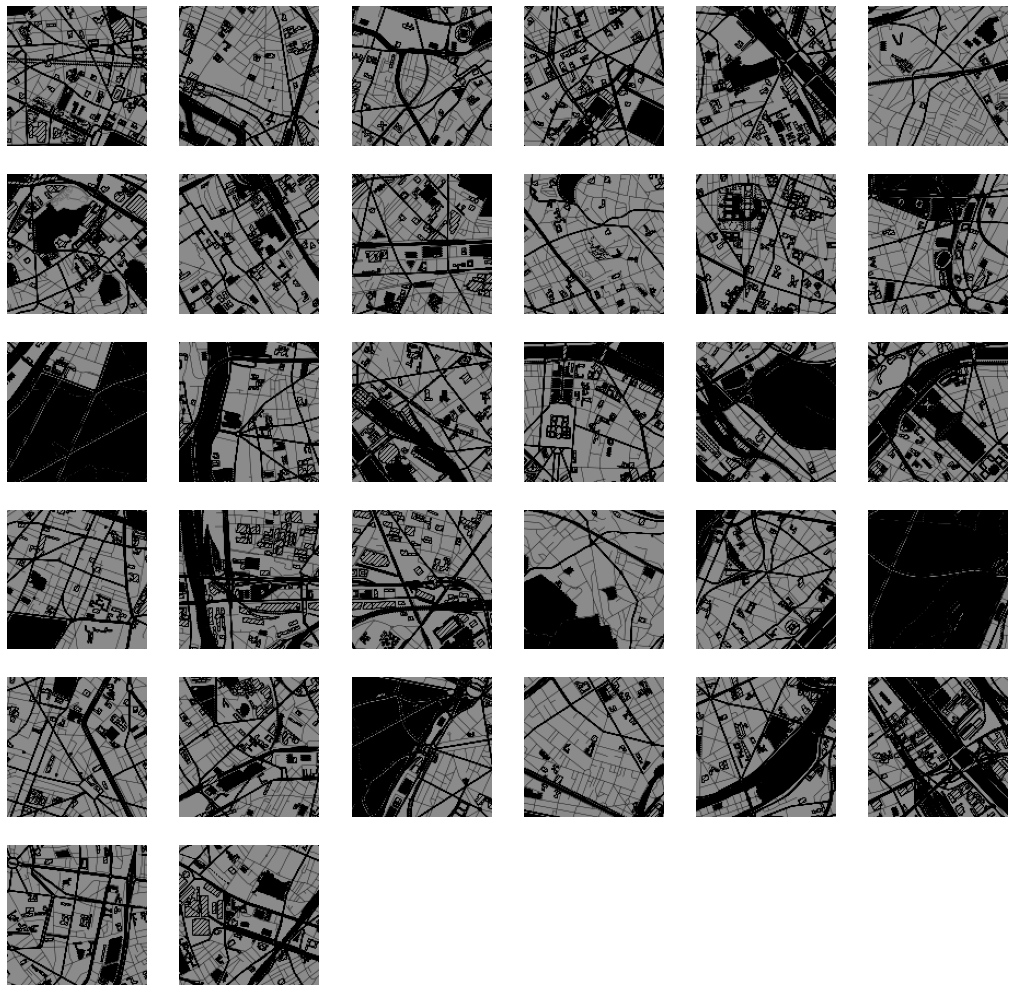

In [67]:
# Instantiate Multisource Maptiles DataModule
data_root = Path("/data/hayley-old/maptiles_v2/")
cities = ['paris'] #['berlin', 'rome'] #['paris']
styles = ['StamenTonerBackground']#['OSMDefault', 'CartoVoyagerNoLabels']#'StamenWatercolor']#, 'StamenTonerLines' 'StamenTonerBackground']
zooms = ['14']
in_shape = (3,128,128)
batch_size = 32

dm = MultiMaptilesDataModule(
    data_root=data_root,
    cities=cities,
    styles=styles,
    zooms=zooms,
    in_shape=in_shape,
    batch_size=batch_size,
)
dm.setup('fit')

# show a batch
dl = dm.train_dataloader()
batch = next(iter(dl))
x, label_c, label_s = dm.unpack(batch)
info(x)
show_timgs(x)
print(label_c)
print(label_s)

## Define model architecture


In [ ]:
# Init plModule
latent_dim = 10
hidden_dims = [32,64,128,256] #,512]
lr = 1e-4
act_fn = nn.ReLU()
# Specific for BiVAE
adversary_dims = [32,32,32] 
is_contrasive = True # If true, use adv. loss from both content and style codes. Else just style codes
kld_weight = 1.0 # vae_loss = recon_loss + kld_weight * kld_weight
adv_loss_weight = 15. # loss = vae_loss + adv_loss_weight * adv_loss

model = BiVAE(
    in_shape=dm.size(), 
    n_styles=dm.n_styles,
    latent_dim=latent_dim,
    hidden_dims=hidden_dims,
    adversary_dims=adversary_dims,
    learning_rate=lr, 
    act_fn=act_fn,
    size_average=False,
    is_contrasive=is_contrasive,
    kld_weight=kld_weight,
    adv_loss_weight=adv_loss_weight,
)

# model

## Load model

In [ ]:
from src.utils.misc import get_ckpt_path
log_dir = Path((
    "/data/hayley-old/Tenanbaum2000/temp-logs/"
    "BiVAE-C_Maptiles/version_0"
))
ckpt_path = get_ckpt_path(log_dir)
ckpt = pl_load(ckpt_path, map_location=lambda storage, loc: storage)  # dict object
print(ckpt.keys())

In [ ]:
# Load state
model.load_state_dict(ckpt['state_dict'])

## Define a TB writer

In [ ]:
# Get the root log_dir correpsonding to the ckpt_path
log_dir = ckpt_path.parent.parent # eg. Folder called `temp-logs/f{model.name+dm.name}/version7`
tb_writer = SummaryWriter(log_dir=log_dir)

In [ ]:
tb_writer.log_dir

### Recons of inputs from training data

In [ ]:
from src.evaluator.qualitative import show_recon


In [ ]:
best_global_step = ckpt['global_step']
best_global_step

In [ ]:
show_recon(
    model=model, 
    dm=dm, 
    tb_writer=tb_writer, 
    global_step=best_global_step, 
    verbose=True
)

# TODO:
- Test src.evaluator.qualitative.evaluate_transfers
  - when constant_code is 'c' (ie. content transfers)
  - when 's' is contant (ie. style transfers)
  
- The evaulation script on the top 3 trained BiVAE from yesterday
- Run more training?
- OSMNX - compare embedding

In [ ]:
from collections import defaultdict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


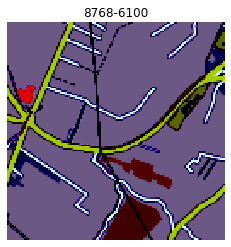

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


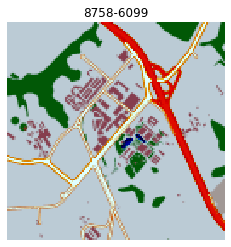

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


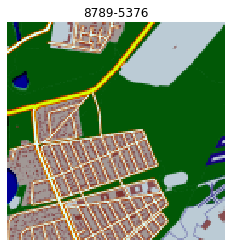

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


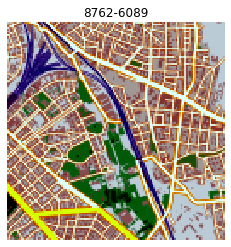

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


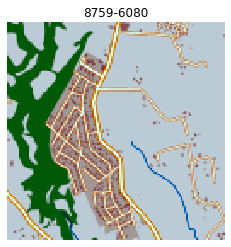

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


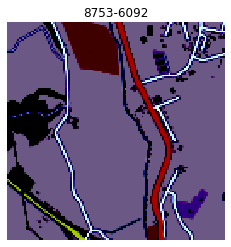

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


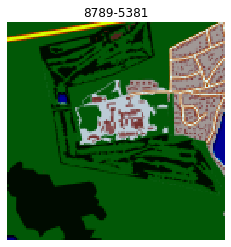

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


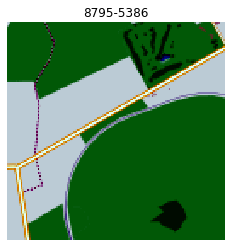

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


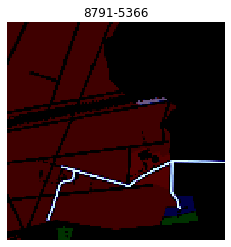

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


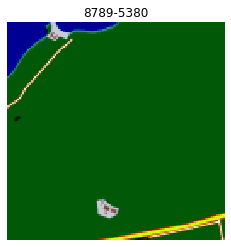

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


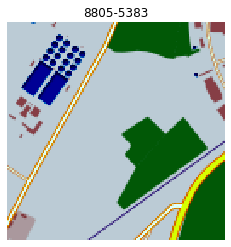

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


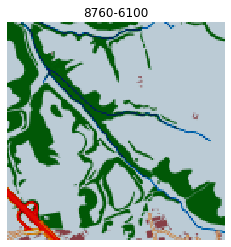

In [57]:
content_samples = dm.get_content_samples(12)
# Show content-representative images
for label_c, timg in content_samples.items():
    show_timg(timg, title=label_c)
    plt.show()

Created:  /data/hayley-old/Tenanbaum2000/temp-logs/BiVAE-C_Maptiles/version_0/content_transfers
Created:  /data/hayley-old/Tenanbaum2000/temp-logs/BiVAE-C_Maptiles/version_0/content_transfers/version_0


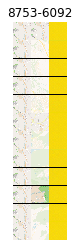

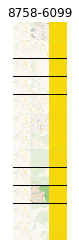

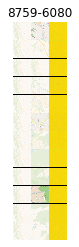

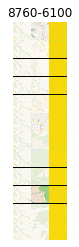

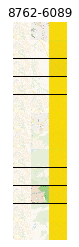

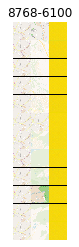

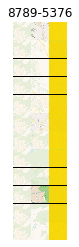

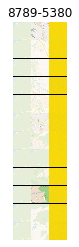

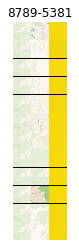

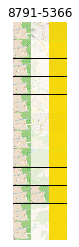

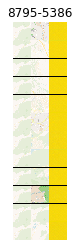

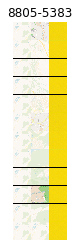

In [59]:
save_content_transfers(model,
                      class_reps=content_samples, 
                       log_dir=log_dir, 
                       train_mean=dm.train_mean, 
                       train_std=dm.train_std);


Created:  /data/hayley-old/Tenanbaum2000/temp-logs/BiVAE-C_Maptiles/version_0/style_transfers
Created:  /data/hayley-old/Tenanbaum2000/temp-logs/BiVAE-C_Maptiles/version_0/style_transfers/version_0


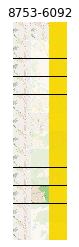

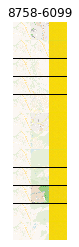

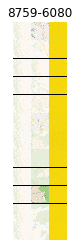

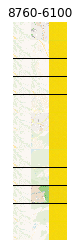

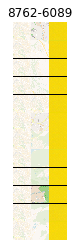

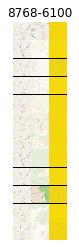

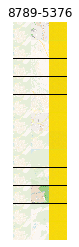

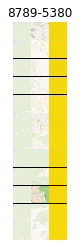

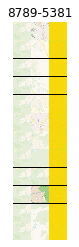

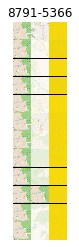

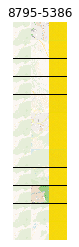

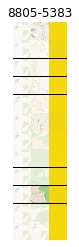

In [58]:
save_style_transfers(model,
                      class_reps=content_samples, 
                       log_dir=log_dir, 
                       train_mean=dm.train_mean, 
                       train_std=dm.train_std);

## Visualize original images of the close neighbors in the latent space
- Compute pairwise distance using cosine similarity
- For each row (ie. a latent code), get the index of the smallest values. 
- Select the images in the batch x and visualize (can do this all in show_timgs)



In [60]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

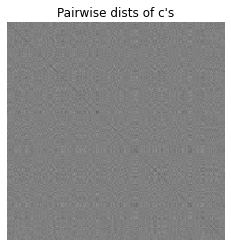

ValueError: 'c' argument has 3542 elements, which is inconsistent with 'x' and 'y' with size 1771.

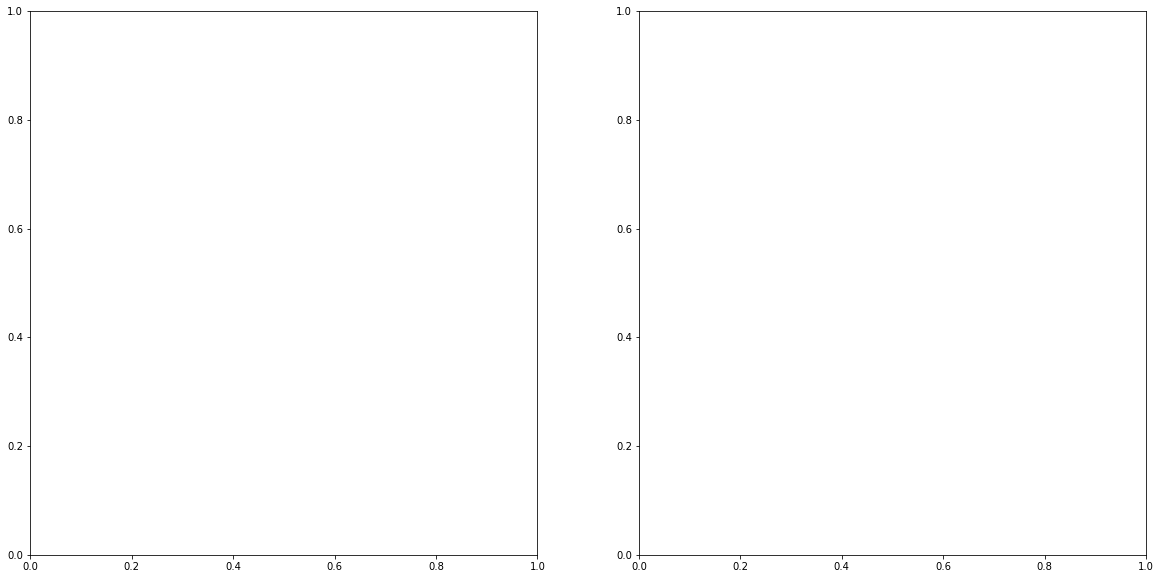

In [61]:
model.eval()
mode = 'train'
ds = getattr(dm, f"{mode}_ds")
query_size = min(len(ds), 50000)# #4096#2048#1024
dl = DataLoader(ds, batch_size=query_size, shuffle=True)


pdist_metric = 'cosine' #pairwise distance metric in content space

# tsne params
tsne_dim = 2
tsne_p = 5. #10 #perplexity
# tsne_metric = 'euclidean'
tsne_metric = 'cosine' 
tsne = TSNE(n_components=tsne_dim, metric=tsne_metric, perplexity=tsne_p)

# Nearest code query param
n_ngbrs = 10
max_num_query = 32
with torch.no_grad():
    batch = next(iter(dl))
    x, label_c, label_s = dm.unpack(batch)

    dict_qparams = model.encode(x)
    dict_z = model.rsample(dict_qparams)
    c = dict_z['c']
    s = dict_z['s']
    z = model.combine_content_style(dict_z)

    for name, embedding in zip(["c", "s", "z"], [c, s, z]):
        # Compute pairwise distance of the embeddings
        pdists = pairwise_distances(embedding.numpy(), metric=pdist_metric)
        plt.imshow(pdists, cmap='gray')
        plt.title(f"Pairwise dists of {name}'s")
        plt.axis('off')
        plt.show()
        
        # show TSNE2d of each code
        embedding_2d = tsne.fit_transform(embedding)
        
        f, ax = plt.subplots(1,2, figsize=(20,10))
        # first plot the 2dim embeddings and color-code by content id
        ax[0].scatter(embedding_2d[:,0], embedding_2d[:,1],
                     c = label_c)
        ax[0].set_title(f"Code: {name}, colored by content-id")
        
        # same embedding plot, but color-code by style-id
        ax[1].scatter(embedding_2d[:,0], embedding_2d[:,1],
                     c = label_s),
        ax[1].set_title(f"Code: {name}, colored by style-id")
        
        plt.show()
        
        # Nearest neighbor queries
        # smaller values means closer in distance
        n_rows = min(query_size, max_num_query)

        selected_rows = np.random.choice(len(x), size=n_rows)
        for idx in selected_rows:
            args = np.argsort(pdists[idx])[:n_ngbrs]
    #         print(args)
            show_timgs(LinearRescaler()(x[args]), cmap='gray', factor=2, 
                       nrows=1, title=f'Nearest of digit {label_c[idx].item()}: {name}')
            plt.show()

## Generate new style codes via. style code interpolation
Added: Jan 18, 2021
1. Get the cluster centers from style code embeddings: r,g,b codes
2. new style code = interpolate (r,g,b)
3. Take an image -> get its content code -> z = [c, new_style] -> generator?
  - z = [c, r] -> generator
  - z = [c, g] -> gen
  - z = [c, b] -> gen

In [ ]:
from sklearn.cluster import KMeans
from torch import linalg as LA

In [ ]:
n_styles = dm.n_styles
model.eval()
mode = 'train'
query_size = 128 #1024
metric = 'cosine' #pairwise distance metric in content space
ds = getattr(dm, f"{mode}_ds")
dl = DataLoader(ds, batch_size=query_size, shuffle=True)

# tsne params
tsne_dim = 2
tsne_p = 5. #10 #perplexity
# tsne_metric = 'euclidean'
tsne_metric = 'cosine' 
tsne = TSNE(n_components=tsne_dim, metric=tsne_metric, perplexity=tsne_p )


with torch.no_grad():
    batch = next(iter(dl))
    x, label_c, label_s = dm.unpack(batch)

    dict_qparams = model.encode(x)
    dict_z = model.rsample(dict_qparams)
    c = dict_z['c']
    s = dict_z['s']
    z = model.combine_content_style(dict_z)
    # mean norm of each code
    norm_c = LA.norm(c, dim=-1)
    norm_s = LA.norm(s, dim=-1)
    print("Avg. norm of content content: ", norm_c.mean())
    print("Avg. norm of style content: ", norm_s.mean())
    
    # kmeans clustering on style codes
    kmeans = KMeans(n_clusters=n_styles, random_state=0).fit(s)
    centers = torch.tensor(kmeans.cluster_centers_)
    breakpoint()
    
    # add centers to the s codes:
    s_and_centers = torch.cat([s, centers], dim=0)
    print(s_and_centers.shape)
    
    for name, embedding in [("s", s_and_centers)]:# zip(["c", "s", "z"], [c,s,z]):
        # Compute pairwise distance of the embeddings
        pdists = pairwise_distances(embedding.numpy(), metric=metric)
        plt.imshow(pdists, cmap='gray')
        plt.title(f"Pairwise dists of {name}'s")
        plt.axis('off')
        plt.show()
        
        # show the 2dim view on the codes
        embedding_2d = tsne.fit_transform(embedding)
        colors = torch.cat([label_s, torch.tensor([n_styles]*dm.n_styles)])
        f, ax = plt.subplots(figsize=(20,10))
        # Plot the 2dim embeddings and color-code by style id
        ax.scatter(embedding_2d[:,0], embedding_2d[:,1],
                     c = colors)
        ax.set_title(f"Code: {name}, colored by style-id")
        
        plt.show()
    
    
# todo: use the r,g,b representative codes + any content code -> decoder

- For each content-label, compute the mean content code
- For each style-label, compute the mean style code


In [ ]:
# n_styles = dm.n_styles
# n_contents = dm.n_contents
# model.eval()
# mode = 'train'
# ds = getattr(dm, f"{mode}_ds")
# query_size = len(ds) #1024
# dl = DataLoader(ds, batch_size=query_size, num_workers=16, pin_memory=True)

# with torch.no_grad():
#     batch = next(iter(dl))
#     x = batch['img']
#     label_c = batch['digit']  # digit/content label (int) -- currently not used
#     label_s = batch['color']

#     dict_qparams = model.encode(x)
#     mu_qc = dict_qparams['mu_qc']
#     mu_qs = dict_qparams['mu_qs']
    
#     dict_z = model.rsample(dict_qparams)
#     c = dict_z['c']
#     s = dict_z['s']
#     z = model.combine_content_style(dict_z)
#     # mean norm of each code
#     norm_c = LA.norm(c, dim=-1)
#     norm_s = LA.norm(s, dim=-1)
#     print("Avg. norm of content content: ", norm_c.mean())
#     print("Avg. norm of style content: ", norm_s.mean())
    

#     content_avgs = {}
#     mu_qc_avgs = {}
#     min_mu_qcs = {}
#     max_mu_qcs = {}
#     for content_id in range(n_contents):
#         mean_mu_qc = mu_qc[label_c == content_id].mean(dim=0)
#         mu_qc_avgs[content_id] = mean_mu_qc # this fails to make desired reconstruction

#         min_mu_qcs[content_id]= mu_qc[label_c == content_id].min(dim=0)
#         max_mu_qcs[content_id]= mu_qc[label_c == content_id].max(dim=0)
        
#         # Must use the mean of samples!
#         mean_c = c[label_c == content_id].mean(dim=0)
#         content_avgs[content_id] = mean_c
        
        
#     style_avgs = {}
#     mu_qs_avgs = {}
#     min_mu_qss = {}
#     max_mu_qss = {}
#     for style_id in range(n_styles):
#         mean_mu_qs = mu_qs[label_s == style_id].mean(dim=0)
#         mu_qs_avgs[style_id] = mean_mu_qs # this fails to make desired reconstruction
        
#         min_mu_qss[style_id]= mu_qs[label_s == style_id].min(dim=0)
#         max_mu_qss[style_id]= mu_qs[label_s == style_id].max(dim=0)
        
#         mean_s = s[label_s == style_id].mean(dim=0)
#         style_avgs[style_id] = mean_s      

In [ ]:
from src.evaluator.qualitative import compute_avg_codes

In [ ]:
avg_codes = compute_avg_codes(model, dm)
mu_qc_avgs = avg_codes['mu_qc_avgs']
mu_qs_avgs = avg_codes['mu_qs_avgs']

mu_qc_mins = avg_codes['mu_qc_mins']
mu_qs_mins = avg_codes['mu_qs_mins']

mu_qc_maxs = avg_codes['mu_qc_maxs']
mu_qs_maxs = avg_codes['mu_qs_maxs']

content_avgs = avg_codes['content_avgs']
style_avgs = avg_codes['style_avgs']

In [ ]:
# Content/Style transfer using the content-class and style-class representatives
content_reps = content_avgs
style_reps = style_avgs

# Or
# content_reps = mu_qc_avgs
# style_reps = mu_qs_avgs

n_contents = dm.n_contents
linearlize = True
cmap = 'gray' if dm.in_shape[0] == 1 else None
train_mean, train_std = dm.train_mean, dm.train_std
f, axes = plt.subplots(nrows=n_contents, ncols=n_styles, figsize=(n_styles*3.,n_contents*3.))
# ax = ax.flatten()
for content_id, c in content_reps.items():
    for style_id, s in style_reps.items():
        dict_z = {'c': c[None], 's': s[None]}
        
        with torch.no_grad():
            z = model.combine_content_style(dict_z)
            
            # Reconstruct
            recons = model.decode(z)

            # Optional: for better viz, unnormalize or/and linearlize
            unnormed_recons = unnormalize(recons, train_mean, train_std)
            if linearlize:
                unnormed_recons = LinearRescaler()(unnormed_recons)
            ax = axes[content_id][style_id]
            ax.imshow(unnormed_recons[0].permute((1,2,0)), cmap=cmap)
            ax.set_axis_off()
            ax.set_title(f"Content: {content_id}, Style: {style_id}")

            

## Distribution of qparams for content/style codes
Given a batch of images with the same content, 
we hypothesize/an ideally leanred model will put their content codes in a close neighborhood in the content latent space. Then, the average of a batch of mu_qc's will be a vector that indicates the center/mean of the mu_qc of each image (whose content-id is the same across the input batch).

- Show the histogram of each dimension's mu_qc_j across the batch: one histogram for each dimension j
- Compute the average mu_qc over the batch of mu_qc's. Then, use it as the input content code with some input image's style code to the generator. What is the generated output? Does its content look something like the content of the batch of image?


In [ ]:
mu_xlim = (-4., 4.)
# var_xlim = (0, 0.05)
n_samples = 1024
# Set output dir
out_dir = log_dir/"dist_qparams_per_content"
if not out_dir.exists():
    out_dir.mkdir(parents=True)
    print("Created and saving to: ", out_dir)
    
for digit_id in range(10):
    # Collect a batch of images of the same content
    xs = []
    n_collected = 0
    while n_collected <= n_samples:
        batch = next(iter(dl))
        x = batch['img']
        label_c = batch['digit']
        label_s = batch['color']
        selected = x[label_c==digit_id]
        xs.append(selected)
        n_collected += len(selected)
    xs = torch.cat(xs, dim=0)
    print(f" Digit {digit_id} collected. Input: {xs.shape}")


    # Plot the distributions of qc parameters and qs parameters
    model.eval()
    with torch.no_grad():
        dict_qparams = model(xs)

        # Dist. of each content dim's parameters
        mu_qc, var_qc = dict_qparams['mu_qc'], dict_qparams['logvar_qc'].exp() #(BS, content_dim), (BS, style_dim)
        # -- mu_qc's
#         mu_xlim = (0, max(mu_qc)
        f, ax = plt.subplots(1, model.content_dim, figsize=(20,2))
        title = f"Digit {digit_id}: " + r"Dist. of $mu^{c}_j$"
        f.suptitle(title)
        for j in range(model.content_dim):
            ax[j].hist(mu_qc[:,j])
            ax[j].set_xlim(mu_xlim)
            ax[j].set_title(f"dim {j}")
        f.tight_layout()
        f.savefig(out_dir/f"digit-{digit_id}-mu_qc.png")
        plt.show()
        
        # -- var_qc's
        var_xlim = (0, var_qc.max().item())
        f, ax = plt.subplots(1, model.style_dim, figsize=(20,2))
        title = f"Digit {digit_id}: " + r"Dist. of $var^{c}_j$"
        f.suptitle(title)
        for j in range(model.content_dim):
            ax[j].hist(var_qc[:,j])
            ax[j].set_xlim(var_xlim)
            ax[j].set_title(f"dim {j}")
        f.tight_layout()
        f.savefig(out_dir/f"digit-{digit_id}-var_qc.png")
        plt.show()

        
        # Dist. of each style dim's parameters
        mu_qs, var_qs = dict_qparams['mu_qs'], dict_qparams['logvar_qs'].exp()
        # -- mu_qs's
#         mu_xlim = (0, max(mu_qs))
        f, ax = plt.subplots(1, model.style_dim, figsize=(20,2))
        title = f"Digit {digit_id}: " + r"Dist. of $mu^{s}_j$"
        f.suptitle(title)
        for j in range(model.style_dim):
            ax[j].hist(mu_qs[:,j])
            ax[j].set_xlim(mu_xlim)
            ax[j].set_title(f"dim {j}")
        f.tight_layout()
        f.savefig(out_dir/f"digit-{digit_id}-mu_qs.png")
        plt.show()
        
        # -- var_qs's
        var_xlim = (0, var_qs.max().item())
        f, ax = plt.subplots(1, model.style_dim, figsize=(20,2))
        title = f"Digit {digit_id}: " + r"Dist. of $var^{s}_j$"
        f.suptitle(title)
        for j in range(model.style_dim):
            ax[j].hist(var_qs[:,j])
            ax[j].set_xlim(var_xlim)
            ax[j].set_title(f"dim {j}")
        f.tight_layout()
        f.savefig(out_dir/f"digit-{digit_id}-var_qs.png")
        plt.show()

- Collect a batch of images with the same style: one such batch for style.
Then plot the histogram of mu_qs_j over the batch: one histogram for a dimension of a style code.

In [ ]:
mu_xlim = (-4., 4.)
# var_xlim = (0, 0.05)
n_samples = 1024
# Set output dir
out_dir = log_dir/"dist_qparams_per_style"
if not out_dir.exists():
    out_dir.mkdir(parents=True)
    print("Created and saving to: ", out_dir)
    
for style_id in range(n_styles):
    # Collect a batch of images of the same content
    xs = []
    n_collected = 0
    while n_collected <= n_samples:
        batch = next(iter(dl))
        x = batch['img']
        label_c = batch['digit']
        label_s = batch['color']
        selected = x[label_c==style_id]
        xs.append(selected)
        n_collected += len(selected)
    xs = torch.cat(xs, dim=0)
    print(f"Style {style_id} collected. Input: {xs.shape}")


    # Plot the distributions of qc parameters and qs parameters
    model.eval()
    with torch.no_grad():
        dict_qparams = model(xs)

        # Dist. of each content dim's parameters
        mu_qc, var_qc = dict_qparams['mu_qc'], dict_qparams['logvar_qc'].exp() #(BS, content_dim), (BS, style_dim)
        # -- mu_qc's
#         mu_xlim = (0, max(mu_qc)
        f, ax = plt.subplots(1, model.content_dim, figsize=(20,2))
        title = f"Style {style_id}: " + r"Dist. of $mu^{c}_j$"
        f.suptitle(title)
        for j in range(model.content_dim):
            ax[j].hist(mu_qc[:,j])
            ax[j].set_xlim(mu_xlim)
            ax[j].set_title(f"dim {j}")
        f.tight_layout()
        f.savefig(out_dir/f"Style-{style_id}-mu_qc.png")
        plt.show()
        
        # -- var_qc's
        var_xlim = (0, var_qc.max().item())
        f, ax = plt.subplots(1, model.style_dim, figsize=(20,2))
        title = f"Style {stlye_id}: " + r"Dist. of $var^{c}_j$"
        f.suptitle(title)
        for j in range(model.content_dim):
            ax[j].hist(var_qc[:,j])
            ax[j].set_xlim(var_xlim)
            ax[j].set_title(f"dim {j}")
        f.tight_layout()
        f.savefig(out_dir/f"Style-{stlye_id}-var_qc.png")
        plt.show()

        
        # Dist. of each style dim's parameters
        mu_qs, var_qs = dict_qparams['mu_qs'], dict_qparams['logvar_qs'].exp()
        # -- mu_qs's
#         mu_xlim = (0, max(mu_qs))
        f, ax = plt.subplots(1, model.style_dim, figsize=(20,2))
        title = f"Style {stlye_id}: " + r"Dist. of $mu^{s}_j$"
        f.suptitle(title)
        for j in range(model.style_dim):
            ax[j].hist(mu_qs[:,j])
            ax[j].set_xlim(mu_xlim)
            ax[j].set_title(f"dim {j}")
        f.tight_layout()
        f.savefig(out_dir/f"Style-{stlye_id}-mu_qs.png")
        plt.show()
        
        # -- var_qs's
        var_xlim = (0, var_qs.max().item())
        f, ax = plt.subplots(1, model.style_dim, figsize=(20,2))
        title = f"Style {stlye_id}: " + r"Dist. of $var^{s}_j$"
        f.suptitle(title)
        for j in range(model.style_dim):
            ax[j].hist(var_qs[:,j])
            ax[j].set_xlim(var_xlim)
            ax[j].set_title(f"dim {j}")
        f.tight_layout()
        f.savefig(out_dir/f"Style-{stlye_id}-var_qs.png")
        plt.show()

## Latent Space Traversal: Content space

### Linear traversal in a single dimension

For each content-id's representative code:
  - Fix a style code representative
  - Traverse for each dim of the content code
  - Put the results in a grid where each colm is the dimension of the content and each row shows the traversed content code's reconstruction result (in combination with the fixed style code representative)

In [ ]:
from src.evaluator.qualitative import get_traversals, run_content_traversal, run_style_traversal
from src.utils.misc import now2str

In [ ]:
content_reps = content_avgs
style_reps = style_avgs

# Or
# content_reps = mu_qc_avgs
# style_reps = mu_qs_avgs

# Run content traversals for each content code that is a representative of each content class
n_traversals = 20
out_dir = log_dir/"content_traversals_of_reps"
run_name = now2str()
to_save = True
to_show = False
if not out_dir.exists():
    out_dir.mkdir(parents=True)
    print("Created: ", out_dir)

for content_id in range(n_contents):
    c = content_reps[content_id]
    content_dim = c.shape[-1]
    traversal_start = mu_qc_mins[content_id]
    traversal_end = mu_qc_maxs[content_id]
#     traversal_start = torch.zeros_like(c).fill_(-3.0)#mu_qc_mins[content_id]
#     traversal_end =  torch.zeros_like(c).fill_(3.0)# mu_qc_maxs[content_id]
    
    
    for style_id in range(n_styles):
        s = style_reps[style_id]
        
        # Traverse for each dim
        title = f"Content Traversal: content {content_id}, style {style_id}"
        run_content_traversal(model, c, s, 
                              traversal_start=traversal_start,
                             traversal_end=traversal_end,
                             n_traversals=n_traversals,
                            show=to_show, 
                            title=title,
                             to_save=to_save,
                             out_path=out_dir/f"content_traversals_c-{content_id}_s-{style_id}_{run_name}.png")

In [ ]:
# for content_id in range(n_contents):
#     c = content_reps[content_id]
#     content_dim = c.shape[-1]

#     for style_id in range(n_styles):
#         s = style_reps[style_id]
        
#         # Traverse for each dim
#         n_traversals = 10
#         grids = [] #k,v = dim_i, batch of recons while traversing in dim_i direction (n_traversals, *dim_x)
#         for dim_i in range(content_dim):
#             min_dim_i = mu_qc_mins[content_id][dim_i]
#             max_dim_i = mu_qc_maxs[content_id][dim_i]
#             print(min_dim_i, max_dim_i)

#             c_traversals = get_traversals(c, dim_i, min_dim_i, max_dim_i, n_traversals)
#             dict_z = {
#                 "c": c_traversals, 
#                 "s": s.repeat((n_traversals, 1))
#                      }
#             z = model.combine_content_style(dict_z)
#             recons = model.decode(z)
#         #     show_timgs(recons, nrows=n_traversals, title=f"Traversal: Content_id:{content_id}, dim:{dim_i}")

#             grid = torchvision.utils.make_grid(recons, nrow=1) # Caveat: nrow is num of colms!
#             grids.append(grid)
#         grids = torch.cat(grids, dim=2)

#         show_timg(grids, title=f"Content Traversal: content {content_id}, style {style_id}")







### General traversal on an input data point
Unlike #1 above where we traversed per content-id code, we do a general traversal on the whole content space, where we used the content/style representative codes, we traverse on the learned latent dimension.

input x -> mu_c, logvar_c
        -> mu_s, logvar_s -> 

#### Latent content space -- Conditioned on the input

In [ ]:
model.eval()
mode = 'train'
ds = getattr(dm, f"{mode}_ds")
query_size = 1
dl = DataLoader(ds, batch_size=query_size, shuffle=True, 
                num_workers=16, pin_memory=True)

to_show = True
to_save = True
n_samples = 10
for i in range(n_samples):
    
    # Encode x to c,s
    with torch.no_grad():
        batch = next(iter(dl))
        x, label_c, label_s =dm.unpack(batch)
        dict_qparams = model.encode(x)
        dict_z = model.rsample(dict_qparams)
        c = dict_z['c'][0]
        s = dict_z['s'][0]

    # Do Content Traversal
    title = f"Content Traversal of {mode} datapt"
    out_dir = log_dir/"content_traversals_of_input"
    to_save = True
    if not out_dir.exists():
        out_dir.mkdir(parents=True)
        print("Created: ", out_dir)

    n_traversals = 20
    traversal_start = -3
    traversal_end = 3
    run_content_traversal(model, c, s, 
                          traversal_start=traversal_start,
                         traversal_end=traversal_end,
                         n_traversals=n_traversals,
                        show=to_show, 
                        title=title,
                         to_save=to_save,
                         out_path=out_dir/f"content_traversals_{now2str()}.png")

#### Latent content space -- Unconditioned on the input; Based on the prior distirbution 

In [ ]:
model.eval()
mode = 'train'
ds = getattr(dm, f"{mode}_ds")
query_size = 1
dl = DataLoader(ds, batch_size=query_size, shuffle=True, 
                num_workers=16, pin_memory=True)


n_samples = 10
for i in range(n_samples):
    # Encode x to c,s
    with torch.no_grad():
        batch = next(iter(dl))
        x, label_c, label_s =dm.unpack(batch)
        dict_qparams = model.encode(x)
        dict_z = model.rsample(dict_qparams)
        c = dict_z['c'][0]
        s = dict_z['s'][0]


    # Content Traversal
    # Use c from the prior distribution
    title = f"Content Traversal based on prior"
    out_dir = log_dir/"content_traversals_unconditioned"
    to_save = True
    if not out_dir.exists():
        out_dir.mkdir(parents=True)
        print("Created: ", out_dir)

    n_traversals = 20
    traversal_start = -4
    traversal_end = 4
    c_prior = torch.zeros_like(c)
    run_content_traversal(model, c_prior, s, 
                          traversal_start=traversal_start,
                         traversal_end=traversal_end,
                         n_traversals=n_traversals,
                        show=True, 
                        title=title,
                         to_save=to_save,
                         out_path=out_dir/(
                             "content_traversals_unconditioned_"
                             f"start-{traversal_start}_end-{traversal_end}_{now2str()}.png"
                         )
                         )


## Latent Space Traversal: Style space

### Linear traversal in a single dimension

For each content-id's representative code:
  - Fix a style code representative
  - Traverse for each dim of the content code
  - Put the results in a grid where each colm is the dimension of the content and each row shows the traversed content code's reconstruction result (in combination with the fixed style code representative)

In [ ]:
from src.evaluator.qualitative import get_traversals
from src.utils.misc import now2str

In [ ]:
# Run content traversals for each content code that is a representative of each content class
n_traversals = 20
out_dir = log_dir/"style_traversals_of_reps"
run_name = now2str()

to_save = True
if not out_dir.exists():
    out_dir.mkdir(parents=True)
    print("Created: ", out_dir)

for style_id in range(n_styles):
    s = style_reps[style_id]
    for content_id in range(n_contents):
        c = content_reps[content_id]
        
        # Traverse for each dim
        traversal_start = mu_qs_mins[style_id]
        traversal_end = mu_qs_maxs[style_id]
    #     traversal_start = torch.zeros_like(c).fill_(-3.0)#mu_qc_mins[content_id]
    #     traversal_end =  torch.zeros_like(c).fill_(3.0)# mu_qc_maxs[content_id]
        title = f"Style Traversal: content {content_id}, style {style_id}"
        run_style_traversal(model, c, s, 
                              traversal_start=traversal_start,
                             traversal_end=traversal_end,
                             n_traversals=n_traversals,
                            show=True, 
                            title=title,
                             to_save=to_save,
                             out_path=out_dir/f"style_traversals_c-{content_id}_s-{style_id}_{run_name}.png")








### General traversal on an input data point
Unlike #1 above where we traversed per style-id code, we do a general traversal on the whole style space, where we used the content/style representative codes, we traverse on the learned latent style dimension.

input x -> mu_c, logvar_c
        -> mu_s, logvar_s -> 

#### Latent style space -- Conditioned on the input

In [ ]:
model.eval()
mode = 'train'
ds = getattr(dm, f"{mode}_ds")
query_size = 1
dl = DataLoader(ds, batch_size=query_size, shuffle=True, 
                num_workers=16, pin_memory=True)


n_samples = 10
for i in range(n_samples):
    # Encode x to c,s
    with torch.no_grad():
        batch = next(iter(dl))
        x, label_c, label_s =dm.unpack(batch)
        dict_qparams = model.encode(x)
        dict_z = model.rsample(dict_qparams)
        c = dict_z['c'][0]
        s = dict_z['s'][0]

    # Style Traversal
    title = f"Style Traversal conditioned on input"
    out_dir = log_dir/"style_traversals_of_input"
    to_save = True
    if not out_dir.exists():
        out_dir.mkdir(parents=True)
        print("Created: ", out_dir)

    n_traversals = 30
    traversal_start = -3.5
    traversal_end = 3.5
    run_style_traversal(model, c, s, 
                          traversal_start=traversal_start,
                         traversal_end=traversal_end,
                         n_traversals=n_traversals,
                        show=True, 
                        title=title,
                         to_save=to_save,
                         out_path=out_dir/(
                         "style_traversals_conditioned_"
                             f"start-{traversal_start}_end-{traversal_end}_{now2str()}.png"
                         )
)

#### Latent style space -- Unconditioned on the input; Based on the prior distirbution 

In [ ]:
model.eval()
mode = 'train'
ds = getattr(dm, f"{mode}_ds")
query_size = 1
dl = DataLoader(ds, batch_size=query_size, shuffle=True, 
                num_workers=16, pin_memory=True)


n_samples = 10
for i in range(n_samples):
    # Encode x to c,s
    with torch.no_grad():
        batch = next(iter(dl))
        x, label_c, label_s =dm.unpack(batch)
        dict_qparams = model.encode(x)
        dict_z = model.rsample(dict_qparams)
        c = dict_z['c'][0]
        s = dict_z['s'][0]

    # Style Traversal
    # Use c from the prior distribution
    title = f"Style Traversal based on prior"
    out_dir = log_dir/"style_traversals_unconditioned"
    to_save = True
    if not out_dir.exists():
        out_dir.mkdir(parents=True)
        print("Created: ", out_dir)

    n_traversals = 20
    traversal_start = -4
    traversal_end = 4
    s_prior = torch.zeros_like(s)
    run_content_traversal(model, c, s_prior, 
                          traversal_start=traversal_start,
                          traversal_end=traversal_end,
                          n_traversals=n_traversals,
                          show=True, 
                          title=title,
                          to_save=to_save,
                          out_path=out_dir/(
                             "style_traversals_unconditioned_"
                             f"start-{traversal_start}_end-{traversal_end}_{now2str()}.png"
                             )
                         )
